# Load dependencies

In [538]:
import cobra
import libsbml
import lxml

models_directory = '/media/sf_Shared/Systems_biology/Metabolic_models/'
OB3b_directory = '/media/sf_Shared/GEM_OB3b/'
memote_directory = '/home/ensakz/Desktop/memote_m_trichosporium/'
fastas_directory = '/media/sf_Shared/Systems_biology/Fastas_and_annotations/'
inparanoid_directory = '/media/sf_Shared/Systems_biology/InParanoid_runs/'
draft_gems_dir_8 = 'draft_gems/8.OB3b_draft_gem_during_pathway_manual_curation/'
gem_confirmation = 'gem_confirmation/'

In [539]:
iMsOB3b = cobra.io.load_json_model(memote_directory + draft_gems_dir_8 + "bigg_OB3b_18_01_2020.json")

In [228]:
model_Bath = cobra.io.load_json_model(models_directory + "iMcBath.json")

In [5]:
model_universal = cobra.io.load_json_model(models_directory + 'universal_model.json')

In [6]:
model_parvus = cobra.io.read_sbml_model(models_directory + "Methylocystis_parvus.xml")

Before you start, fix reaction annotation in GEM:

In [541]:
for reaction in iMsOB3b.reactions:
    reaction.annotation = {}

In [13]:
cobra.io.save_json_model(iMsOB3b, memote_directory + draft_gems_dir_8 + "bigg_OB3b_19_01_2020.json")

# Adjust reaction bounds

In [542]:
iMsOB3b.reactions.EX_ch4_e.bounds = (-14.9, 0)

# Growth on molecular nitrogen:

Check whether there is in silico growth rate using molecular nitrogen:

In [35]:
iMsOB3b.reactions.EX_nh4_e.bounds = (0, 0)

In [22]:
iMsOB3b.summary()

IN FLUXES    OUT FLUXES    OBJECTIVES
-----------  ------------  --------------------------
o2_e   2     h2o_e  2      Biomass_Mext...  -1.29e-17
ch4_e  1     co2_e  1


In [23]:
iMsOB3b.reactions.EX_n2_e.bounds = (-1000, 0)

In [24]:
iMsOB3b.summary()

IN FLUXES    OUT FLUXES    OBJECTIVES
-----------  ------------  --------------------------
o2_e   2     h2o_e  2      Biomass_Mext...  -1.29e-17
ch4_e  1     co2_e  1


In [25]:
iMsOB3b.reactions.EX_n2_e

Reaction identifier,EX_n2_e
Name,N2 exchange
Memory address,0x07fee0d99c0f0
Stoichiometry,n2_e <-- dinitrogen <--
GPR,
Lower bound,-1000
Upper bound,0


In [26]:
iMsOB3b.metabolites.n2_p

Metabolite identifier,n2_p
Name,dinitrogen
Memory address,0x07fee0b783438
Formula,N2
Compartment,p
In 2 reaction(s),"N2trpp, N2tex"


In [27]:
iMsOB3b.reactions.N2tex

Reaction identifier,N2tex
Name,"Nitrogen exchange, diffusion (extra-organism to periplasm)"
Memory address,0x07fee0dbb8f60
Stoichiometry,n2_e <=> n2_p dinitrogen <=> dinitrogen
GPR,
Lower bound,-1000.0
Upper bound,1000.0


In [28]:
iMsOB3b.reactions.N2trpp

Reaction identifier,N2trpp
Name,"Nitrogen exchange, diffusion (periplasm)"
Memory address,0x07fee0dbb8dd8
Stoichiometry,n2_p <=> n2_c dinitrogen <=> dinitrogen
GPR,
Lower bound,-1000.0
Upper bound,1000.0


In [29]:
iMsOB3b.reactions.NIT_mc

Reaction identifier,NIT_mc
Name,Nitrogenase
Memory address,0x07fee0d99ce80
Stoichiometry,16.0 atp_c + 4.0 fdxrd_c + 16.0 h2o_c + n2_c --> 16.0 adp_c + 4.0 fdxox_c + h2_c + 14.0 h_c + 2.0 nh4_c + 16.0 pi_c 16.0 ATP + 4.0 reduced_ferredoxin + 16.0 H2O + dinitrogen --> 16.0 ADP + 4.0 oxidized_ferredoxin + H2 + 14.0 H_ + 2.0 NH3 + 16.0 phosphate
GPR,CQW49_08720 and CQW49_08725
Lower bound,0.0
Upper bound,1000.0


## Compare modes of methane oxidation after GAM/NGAM adjustments: NO3
GAM: AM1, NGAM: Methylocystis parvus (default condition)
<br> create pandas dataframe to store results:

In [579]:
iMsOB3b.reactions.FALDA.bounds = (0, 0)
iMsOB3b.reactions.EX_nh4_e.bounds = (0, 0)
iMsOB3b.reactions.EX_n2_e.bounds = (0, 0)
iMsOB3b.reactions.EX_no3_e.bounds = (-1000, 0)

In [580]:
import pandas as pd
df = pd.DataFrame(index=["Methane UTR","Oxygen UTR", "CO2 UTR", "NH4 UTR", "N2 UTR",
                         "NO3 UTR", "Uphill Electron Transfer Flux", "Growth Rate" ,
                         "Growth Yield", "O2/CH4 Ratio", "NH4/CH4 Ratio", "N2/CH4 Ratio",
                         "NO3/CH4 Ratio", "ATP/CH4 Ratio"])

In [581]:
def df_record(solution, df, column):
    gr = solution.fluxes.Biomass_Mextorquens_AM1_core
    yx = gr/(abs((solution.fluxes.EX_ch4_e/1000)*16.04))
    data = [solution.fluxes.EX_ch4_e, solution.fluxes.EX_o2_e, solution.fluxes.EX_co2_e, solution.fluxes.EX_nh4_e,
            solution.fluxes.EX_n2_e, solution.fluxes.EX_no3_e, solution.fluxes.UQCYOR_2p, gr, yx,
            solution.fluxes.EX_o2_e/solution.fluxes.EX_ch4_e, solution.fluxes.EX_nh4_e/solution.fluxes.EX_ch4_e,
            solution.fluxes.EX_n2_e/solution.fluxes.EX_ch4_e, solution.fluxes.EX_no3_e/solution.fluxes.EX_ch4_e,
            solution.fluxes.ATPS4rpp/abs(solution.fluxes.EX_ch4_e)]
    df[column] = data
    return df

### Direct coupling:

- Integrate redox arm and direct coupling with different ratios at the same time

In [582]:
for r in np.arange(0,6.5,0.5):
    with iMsOB3b as model:
        try:
            model.reactions.EX_no3_e.bounds = -1000, 0
            model.reactions.PMMOipp.bounds = 0, 1000
            model.reactions.PMMODCipp.bounds = 0, 1000
            c3 = model.problem.Constraint(
                    model.reactions.PMMOipp.flux_expression - 
                    r* model.reactions.PMMODCipp.flux_expression, lb=0, ub=0, name='c3')
            model.add_cons_vars(c3)
            solution = cobra.flux_analysis.pfba(model)
            print(solution.fluxes.MEOHDH,solution.fluxes.PMMODCipp, solution.fluxes.PMMOipp)
        except:
            #pass
            print(r, 'is infeasible')
    df = df_record(solution, df, 'NO3, pMMODC, RedEff {}'.format(r))

14.9 14.9 0.0
0.5 is infeasible
14.9 7.45 7.45
14.9 5.959999999999999 8.940000000000001
2.0 is infeasible
14.9 4.257142857142858 10.642857142857142
14.9 3.7249999999999996 11.175
14.9 3.311111111111112 11.588888888888889
14.89999999999647 2.9799999999992934 11.919999999997177
14.900000054940708 2.709090919080129 12.19090913586058
14.899999976020213 2.483333329336702 12.416666646683511
14.900000000137059 2.2923076923287784 12.60769230780828
14.900000000148719 2.128571428592675 12.771428571556044


There is a problem with pFBA when simulating via direct coupling mode of methane oxidation.

In [583]:
df

,"NO3, pMMODC, RedEff 0.0","NO3, pMMODC, RedEff 0.5","NO3, pMMODC, RedEff 1.0","NO3, pMMODC, RedEff 1.5","NO3, pMMODC, RedEff 2.0","NO3, pMMODC, RedEff 2.5","NO3, pMMODC, RedEff 3.0","NO3, pMMODC, RedEff 3.5","NO3, pMMODC, RedEff 4.0","NO3, pMMODC, RedEff 4.5","NO3, pMMODC, RedEff 5.0","NO3, pMMODC, RedEff 5.5","NO3, pMMODC, RedEff 6.0"
Methane UTR,-14.900000,-14.900000,-14.900000,-14.900000,-14.900000,-14.900000,-14.900000,-14.900000,-14.900000,-14.900000,-14.900000,-14.900000,-14.900000
Oxygen UTR,-20.759965,-20.759965,-20.759965,-20.759965,-20.759965,-20.759965,-20.759965,-20.759965,-20.874001,-21.009243,-21.121945,-21.217309,-21.299049
CO2 UTR,8.913091,8.913091,8.913091,8.913091,8.913091,8.913091,8.913091,8.913091,8.988613,9.078180,9.152818,9.215974,9.270108
NH4 UTR,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
N2 UTR,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
NO3 UTR,-1.457561,-1.457561,-1.457561,-1.457561,-1.457561,-1.457561,-1.457561,-1.457561,-1.439175,-1.417369,-1.399198,-1.383822,-1.370643
Uphill Electron Transfer Flux,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Growth Rate,0.149004,0.149004,0.149004,0.149004,0.149004,0.149004,0.149004,0.149004,0.147125,0.144895,0.143038,0.141466,0.140119
Growth Yield,0.623459,0.623459,0.623459,0.623459,0.623459,0.623459,0.623459,0.623459,0.615594,0.606267,0.598494,0.591917,0.586280
O2/CH4 Ratio,1.393286,1.393286,1.393286,1.393286,1.393286,1.393286,1.393286,1.393286,1.400940,1.410016,1.417580,1.423980,1.429466


Plot the figure:

In [584]:
df.at['O2/CH4 Ratio', 'NO3, pMMODC, RedEff 0.5'] = 0.00
df.at['O2/CH4 Ratio', 'NO3, pMMODC, RedEff 2.0'] = 0.00

In [585]:
df.iloc[9]['NO3, pMMODC, RedEff 0.0':'NO3, pMMODC, RedEff 6.0']

NO3, pMMODC, RedEff 0.0    1.393286
NO3, pMMODC, RedEff 0.5    0.000000
NO3, pMMODC, RedEff 1.0    1.393286
NO3, pMMODC, RedEff 1.5    1.393286
NO3, pMMODC, RedEff 2.0    0.000000
NO3, pMMODC, RedEff 2.5    1.393286
NO3, pMMODC, RedEff 3.0    1.393286
NO3, pMMODC, RedEff 3.5    1.393286
NO3, pMMODC, RedEff 4.0    1.400940
NO3, pMMODC, RedEff 4.5    1.410016
NO3, pMMODC, RedEff 5.0    1.417580
NO3, pMMODC, RedEff 5.5    1.423980
NO3, pMMODC, RedEff 6.0    1.429466
Name: O2/CH4 Ratio, dtype: float64

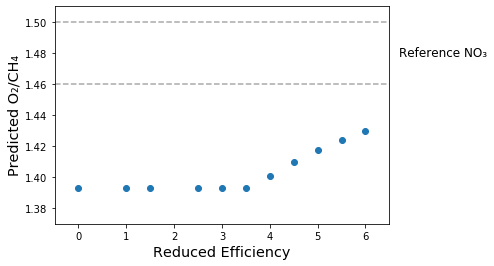

In [576]:
import matplotlib.pyplot as plt
import pandas

x=np.arange(0,6.5,0.5)
plt.scatter(x, y=df.iloc[9]['NO3, pMMODC, RedEff 0.0':'NO3, pMMODC, RedEff 6.0'])
plt.axhline(y=1.46, color='darkgray', linestyle='--')
plt.axhline(y=1.50, color='darkgray', linestyle='--')
plt.text(6.7, 1.478,'Reference NO\u2083', fontsize='large')
#plt.fill_between((-0.5, 6.5), 1.48, 1.50, facecolor = 'darkgray')
plt.xlim((-0.5,6.5))
plt.ylim((1.37,1.51))
plt.xlabel('Reduced Efficiency', fontsize='x-large')
plt.ylabel('Predicted O\u2082/CH\u2084', fontsize='x-large')
plt.show()

### Uphill electron transfer:

- Iteratively limit the flux of reverse electron in uphill electron transfer mode

In [586]:
with iMsOB3b as model:
    model.reactions.UQCYOR_2p.bounds = -1000, 1000
    model.reactions.EX_no3_e.bounds = -1000, 0
    solution = cobra.flux_analysis.pfba(model)

df = df_record(solution, df, 'NO3, pMMO, Uphill Unconstrained')

In [587]:
for r in np.arange(-5,0,0.2):
    with iMsOB3b as model:
        model.reactions.UQCYOR_2p.bounds = r, 1000
        model.reactions.EX_no3_e.bounds = -1000, 0
        solution = cobra.flux_analysis.pfba(model)

    df = df_record(solution, df, 'NO3, pMMO, Uphill ET, {}'.format(r))

Plot the figure:

In [588]:
df.iloc[9]['NO3, pMMO, Uphill ET, -5.0':'NO3, pMMO, Uphill ET, -0.19999999999999574']

NO3, pMMO, Uphill ET, -5.0                    1.393286
NO3, pMMO, Uphill ET, -4.8                    1.393286
NO3, pMMO, Uphill ET, -4.6                    1.393286
NO3, pMMO, Uphill ET, -4.3999999999999995     1.393286
NO3, pMMO, Uphill ET, -4.199999999999999      1.393286
NO3, pMMO, Uphill ET, -3.999999999999999      1.393286
NO3, pMMO, Uphill ET, -3.799999999999999      1.393286
NO3, pMMO, Uphill ET, -3.5999999999999988     1.393286
NO3, pMMO, Uphill ET, -3.3999999999999986     1.393286
NO3, pMMO, Uphill ET, -3.1999999999999984     1.393569
NO3, pMMO, Uphill ET, -2.9999999999999982     1.400270
NO3, pMMO, Uphill ET, -2.799999999999998      1.406970
NO3, pMMO, Uphill ET, -2.599999999999998      1.413671
NO3, pMMO, Uphill ET, -2.3999999999999977     1.420372
NO3, pMMO, Uphill ET, -2.1999999999999975     1.427073
NO3, pMMO, Uphill ET, -1.9999999999999973     1.433774
NO3, pMMO, Uphill ET, -1.7999999999999972     1.440475
NO3, pMMO, Uphill ET, -1.599999999999997      1.447176
NO3, pMMO,

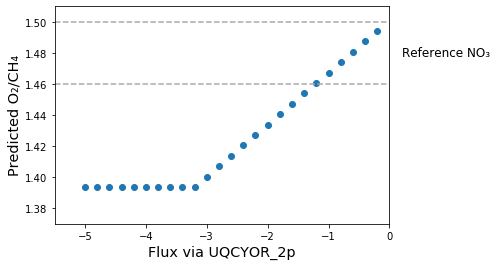

In [589]:
import matplotlib.pyplot as plt
import pandas

x=np.arange(-5,0,0.2)
plt.scatter(x, y=df.iloc[9]['NO3, pMMO, Uphill ET, -5.0':'NO3, pMMO, Uphill ET, -0.19999999999999574'])
plt.axhline(y=1.46, color='darkgray', linestyle='--')
plt.axhline(y=1.50, color='darkgray', linestyle='--')
plt.text(0.2, 1.478,'Reference NO\u2083', fontsize='large')
#plt.fill_between((-5.5,0), 1.48, 1.50, facecolor = 'darkgray')
plt.xlim((-5.5,0))
plt.ylim((1.37,1.51))
plt.xlabel('Flux via UQCYOR_2p', fontsize='x-large')
plt.ylabel('Predicted O\u2082/CH\u2084', fontsize='x-large')
plt.show()

### Redox-arm:

- Value ratio of protons required for synthesis of 1 ATP molecule

In [590]:
iMsOB3b.reactions.ATPS4rpp.metabolites

{<Metabolite adp_c at 0x7fee07314828>: -1.0,
 <Metabolite atp_c at 0x7fee04d60cc0>: 1.0,
 <Metabolite h2o_c at 0x7fee051df400>: 1.0,
 <Metabolite h_c at 0x7fee05c4f828>: 3.0,
 <Metabolite h_p at 0x7fee05c4ffd0>: -4.0,
 <Metabolite pi_c at 0x7fee05d59198>: -1.0}

In [591]:
for r in np.arange(0,2,0.2):
    with iMsOB3b as model:
        #try:
            model.reactions.EX_no3_e.bounds = -1000, 0
            model.reactions.ATPS4rpp.add_metabolites(
                {model.metabolites.adp_c: -1.0, 
                 model.metabolites.atp_c: 1.0,
                 model.metabolites.h2o_c: 1.0,
                 model.metabolites.h_c: (3.0-r),
                 model.metabolites.h_p: -(4.0-r), 
                 model.metabolites.pi_c: -1.0}, combine=False)
            solution = cobra.flux_analysis.pfba(model)
    #         print(model.reactions.ATPS4rpp)
    #         print(solution.fluxes.ATPS4rpp)
        #except:
            #pass

    df = df_record(solution, df, 'NO3, pMMO, Redox-Arm, H/ATP {}'.format(3-r))

Plot the figure:

In [592]:
df.iloc[9]['NO3, pMMO, Redox-Arm, H/ATP 3.0':'NO3, pMMO, Redox-Arm, H/ATP 1.2']

NO3, pMMO, Redox-Arm, H/ATP 3.0                   1.500783
NO3, pMMO, Redox-Arm, H/ATP 2.8                   1.500783
NO3, pMMO, Redox-Arm, H/ATP 2.6                   1.500783
NO3, pMMO, Redox-Arm, H/ATP 2.4                   1.500783
NO3, pMMO, Redox-Arm, H/ATP 2.2                   1.500783
NO3, pMMO, Redox-Arm, H/ATP 2.0                   1.500783
NO3, pMMO, Redox-Arm, H/ATP 1.7999999999999998    1.500783
NO3, pMMO, Redox-Arm, H/ATP 1.5999999999999999    1.500783
NO3, pMMO, Redox-Arm, H/ATP 1.4                   1.500783
NO3, pMMO, Redox-Arm, H/ATP 1.2                   1.500783
Name: O2/CH4 Ratio, dtype: float64

In [638]:
x=np.arange(1.2,3.2,0.2)

In [639]:
x

array([1.2, 1.4, 1.6, 1.8, 2. , 2.2, 2.4, 2.6, 2.8, 3. ])

In [640]:
x[::-1]

array([3. , 2.8, 2.6, 2.4, 2.2, 2. , 1.8, 1.6, 1.4, 1.2])

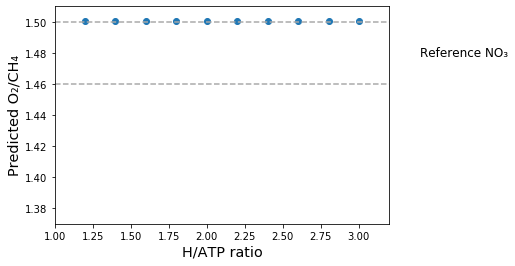

In [646]:
import matplotlib.pyplot as plt
import pandas

x=np.arange(1.2,3.2,0.2)
x=x[::-1]
plt.scatter(x, y=df.iloc[9]['NO3, pMMO, Redox-Arm, H/ATP 3.0':'NO3, pMMO, Redox-Arm, H/ATP 1.2'])
plt.axhline(y=1.46, color='darkgray', linestyle='--')
plt.axhline(y=1.50, color='darkgray', linestyle='--')
plt.text(3.4, 1.478,'Reference NO\u2083', fontsize='large')
#plt.fill_between((-5.5,0), 1.48, 1.50, facecolor = 'darkgray')
plt.xlim((1.0,3.2))
plt.ylim((1.37,1.51))
plt.xlabel('H/ATP ratio', fontsize='x-large')
plt.ylabel('Predicted O\u2082/CH\u2084', fontsize='x-large')
plt.show()

Inspect dataframe:

In [595]:
df

,"NO3, pMMODC, RedEff 0.0","NO3, pMMODC, RedEff 0.5","NO3, pMMODC, RedEff 1.0","NO3, pMMODC, RedEff 1.5","NO3, pMMODC, RedEff 2.0","NO3, pMMODC, RedEff 2.5","NO3, pMMODC, RedEff 3.0","NO3, pMMODC, RedEff 3.5","NO3, pMMODC, RedEff 4.0","NO3, pMMODC, RedEff 4.5",...,"NO3, pMMO, Redox-Arm, H/ATP 3.0","NO3, pMMO, Redox-Arm, H/ATP 2.8","NO3, pMMO, Redox-Arm, H/ATP 2.6","NO3, pMMO, Redox-Arm, H/ATP 2.4","NO3, pMMO, Redox-Arm, H/ATP 2.2","NO3, pMMO, Redox-Arm, H/ATP 2.0","NO3, pMMO, Redox-Arm, H/ATP 1.7999999999999998","NO3, pMMO, Redox-Arm, H/ATP 1.5999999999999999","NO3, pMMO, Redox-Arm, H/ATP 1.4","NO3, pMMO, Redox-Arm, H/ATP 1.2"
Methane UTR,-14.900000,-14.900000,-14.900000,-14.900000,-14.900000,-14.900000,-14.900000,-14.900000,-14.900000,-14.900000,...,-14.900000,-14.900000,-14.900000,-14.900000,-14.900000,-14.900000,-14.900000,-14.900000,-14.900000,-14.900000
Oxygen UTR,-20.759965,-20.759965,-20.759965,-20.759965,-20.759965,-20.759965,-20.759965,-20.759965,-20.874001,-21.009243,...,-22.361667,-22.361667,-22.361667,-22.361667,-22.361667,-22.361667,-22.361667,-22.361667,-22.361667,-22.361667
CO2 UTR,8.913091,8.913091,8.913091,8.913091,8.913091,8.913091,8.913091,8.913091,8.988613,9.078180,...,9.973844,9.973844,9.973844,9.973844,9.973844,9.973844,9.973844,9.973844,9.973844,9.973844
NH4 UTR,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
N2 UTR,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
NO3 UTR,-1.457561,-1.457561,-1.457561,-1.457561,-1.457561,-1.457561,-1.457561,-1.457561,-1.439175,-1.417369,...,-1.199312,-1.199312,-1.199312,-1.199312,-1.199312,-1.199312,-1.199312,-1.199312,-1.199312,-1.199312
Uphill Electron Transfer Flux,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Growth Rate,0.149004,0.149004,0.149004,0.149004,0.149004,0.149004,0.149004,0.149004,0.147125,0.144895,...,0.122604,0.122604,0.122604,0.122604,0.122604,0.122604,0.122604,0.122604,0.122604,0.122604
Growth Yield,0.623459,0.623459,0.623459,0.623459,0.623459,0.623459,0.623459,0.623459,0.615594,0.606267,...,0.512995,0.512995,0.512995,0.512995,0.512995,0.512995,0.512995,0.512995,0.512995,0.512995
O2/CH4 Ratio,1.393286,0.000000,1.393286,1.393286,0.000000,1.393286,1.393286,1.393286,1.400940,1.410016,...,1.500783,1.500783,1.500783,1.500783,1.500783,1.500783,1.500783,1.500783,1.500783,1.500783


Save the simulation results to excel:

In [596]:
df.to_excel(memote_directory + 'gem_confirmation/parameter_comparison/modes_of_methane_oxidation/' +
                    'gam_ngam_fixed_at_default.xls')

In [597]:
df.to_csv(memote_directory + 'gem_confirmation/parameter_comparison/modes_of_methane_oxidation/' +
         'gam_ngam_fixed_at_default.csv')

## Draw figure for comparison of modes of methane oxidation (without parameter fit):

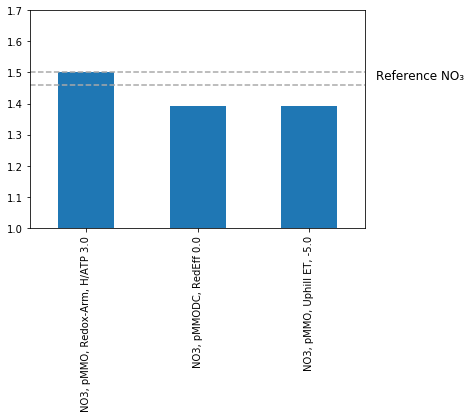

In [737]:
#plt.figure(figsize=(5,3), dpi=300);

plt=df[['NO3, pMMO, Redox-Arm, H/ATP 3.0','NO3, pMMODC, RedEff 0.0', 'NO3, pMMO, Uphill ET, -5.0']].loc['O2/CH4 Ratio'].plot.bar(ylim=(1,1.7))
plt.text(2.6, 1.478,'Reference NO\u2083', fontsize='large')
plt.axhline(y=1.46, color='darkgray', linestyle='--')
plt.axhline(y=1.50, color='darkgray', linestyle='--')
#plt.xlabel('H/ATP ratio', fontsize='x-large')

## Check GEM's in silico parameters under different environmental conditions:
sMMO, pMMO and different nitrogen sources belong to different conditions:

Just noticed that GEM does not have meoh_c <-> meoh_p transport reaction for SMMOi to function:

In [167]:
iMsOB3b.add_reaction(model_Bath.reactions.MEOHtrpp)

Ignoring reaction 'MEOHtrpp' since it already exists.


In [168]:
import pandas as pd
df2 = pd.DataFrame(index=["Methane UTR","Oxygen UTR", "CO2 UTR", "NH4 UTR", "N2 UTR",
                         "NO3 UTR", "Uphill Electron Transfer Flux", "Growth Rate" ,
                          "Growth Yield", "O2/CH4 Ratio", "NH4/CH4 Ratio", "N2/CH4 Ratio",
                         "NO3/CH4 Ratio", "ATP/CH4 Ratio"])

In [169]:
def df_record(solution, df2, column):
    gr = solution.fluxes.Biomass_Mextorquens_AM1_core
    yx = gr/(abs((solution.fluxes.EX_ch4_e/1000)*16.04))
    data = [solution.fluxes.EX_ch4_e, solution.fluxes.EX_o2_e, solution.fluxes.EX_co2_e, solution.fluxes.EX_nh4_e,
            solution.fluxes.EX_n2_e, solution.fluxes.EX_no3_e, solution.fluxes.UQCYOR_2p, gr, yx,
            solution.fluxes.EX_o2_e/solution.fluxes.EX_ch4_e, solution.fluxes.EX_nh4_e/solution.fluxes.EX_ch4_e,
            solution.fluxes.EX_n2_e/solution.fluxes.EX_ch4_e, solution.fluxes.EX_no3_e/solution.fluxes.EX_ch4_e,
            solution.fluxes.ATPS4rpp/abs(solution.fluxes.EX_ch4_e)]
    df2[column] = data
    return df2

NO3, pMMO:

In [170]:
with iMsOB3b as model:
    #try:
        reaction_id = "Biomass_Mextorquens_AM1_core"
        model.objective = reaction_id
        #PARAMETERS:
        #NITROGEN:
        model.reactions.get_by_id('EX_no3_e').bounds = (-1000, 0)
        model.reactions.EX_nh4_e.bounds = (0, 0)
        #METHANE OXIDATION:
        model.reactions.SMMOi.bounds = (0, 0)
        model.reactions.PMMOipp.bounds = (0, 1000)
        model.reactions.PMMODCipp.bounds = (0, 0)
        model.reactions.UQCYOR_2p.bounds = (0, 1000)
        #SIMULATION:
        #solution = model.optimize()
        solution = cobra.flux_analysis.pfba(mcaps)
    #except:
        #pass
df2 = df_record(solution, df2, 'NO3, pMMO'.format(r))

NO3, sMMO:

In [171]:
with iMsOB3b as model:
    #try:
        reaction_id = "Biomass_Mextorquens_AM1_core"
        model.objective = reaction_id
        #PARAMETERS:
        #NITROGEN:
        model.reactions.get_by_id('EX_no3_e').bounds = (-1000, 0)
        model.reactions.EX_nh4_e.bounds = (0, 0)
        #METHANE OXIDATION:
        model.reactions.SMMOi.bounds = (0, 1000)
        model.reactions.PMMOipp.bounds = (0, 0)
        model.reactions.PMMODCipp.bounds = (0, 0)
        model.reactions.UQCYOR_2p.bounds = (0, 1000)
        #SIMULATION:
        #solution = model.optimize()
        solution = cobra.flux_analysis.pfba(mcaps)
    #except:
        #pass
df2 = df_record(solution, df2, 'NO3, sMMO'.format(r))

NH4, pMMO:

In [172]:
with iMsOB3b as model:
    #try:
        reaction_id = "Biomass_Mextorquens_AM1_core"
        model.objective = reaction_id
        #PARAMETERS:
        #NITROGEN:
        model.reactions.get_by_id('EX_no3_e').bounds = (0, 0)
        model.reactions.EX_nh4_e.bounds = (-1000, 0)
        #METHANE OXIDATION:
        model.reactions.SMMOi.bounds = (0, 0)
        model.reactions.PMMOipp.bounds = (0, 1000)
        model.reactions.PMMODCipp.bounds = (0, 0)
        model.reactions.UQCYOR_2p.bounds = (0, 1000)
        #SIMULATION:
        #solution = model.optimize()
        solution = cobra.flux_analysis.pfba(mcaps)
    #except:
        #pass
df2 = df_record(solution, df2, 'NH3, pMMO'.format(r))

NH4, sMMO:

In [173]:
with iMsOB3b as model:
    #try:
        reaction_id = "Biomass_Mextorquens_AM1_core"
        model.objective = reaction_id
        #PARAMETERS:
        #NITROGEN:
        model.reactions.get_by_id('EX_no3_e').bounds = (0, 0)
        model.reactions.EX_nh4_e.bounds = (-1000, 0)
        #METHANE OXIDATION:
        model.reactions.SMMOi.bounds = (0, 1000)
        model.reactions.PMMOipp.bounds = (0, 0)
        model.reactions.PMMODCipp.bounds = (0, 0)
        model.reactions.UQCYOR_2p.bounds = (0, 1000)
        #SIMULATION:
        #solution = model.optimize()
        solution = cobra.flux_analysis.pfba(mcaps)
    #except:
        #pass
df2 = df_record(solution, df2, 'NH3, sMMO'.format(r))

N2, pMMO:

In [176]:
with iMsOB3b as model:
    #try:
        reaction_id = "Biomass_Mextorquens_AM1_core"
        model.objective = reaction_id
        #PARAMETERS:
        #NITROGEN:
        model.reactions.get_by_id('EX_no3_e').bounds = (0, 0)
        model.reactions.EX_nh4_e.bounds = (0, 0)
        model.reactions.EX_n2_e.bounds = (-1000, 0)
        #METHANE OXIDATION:
        model.reactions.SMMOi.bounds = (0, 0)
        model.reactions.PMMOipp.bounds = (0, 1000)
        model.reactions.PMMODCipp.bounds = (0, 0)
        model.reactions.UQCYOR_2p.bounds = (0, 1000)
        #SIMULATION:
        #solution = model.optimize()
        solution = cobra.flux_analysis.pfba(mcaps)
    #except:
        #pass
df2 = df_record(solution, df2, 'N2, pMMO'.format(r))

N2, sMMO:

In [177]:
with iMsOB3b as model:
    #try:
        reaction_id = "Biomass_Mextorquens_AM1_core"
        model.objective = reaction_id
        #PARAMETERS:
        #NITROGEN:
        model.reactions.get_by_id('EX_no3_e').bounds = (0, 0)
        model.reactions.EX_nh4_e.bounds = (0, 0)
        model.reactions.EX_n2_e.bounds = (-1000, 0)
        #METHANE OXIDATION:
        model.reactions.SMMOi.bounds = (0, 1000)
        model.reactions.PMMOipp.bounds = (0, 0)
        model.reactions.PMMODCipp.bounds = (0, 0)
        model.reactions.UQCYOR_2p.bounds = (0, 1000)
        #SIMULATION:
        #solution = model.optimize()
        solution = cobra.flux_analysis.pfba(mcaps)
    #except:
        #pass
df2 = df_record(solution, df2, 'N2, sMMO'.format(r))

In [178]:
df2

,"NO3, pMMO","NO3, sMMO","NH3, pMMO","NH3, sMMO","N2, pMMO","N2, sMMO"
Methane UTR,-14.900000,-14.900000,-14.900000,-14.900000,-0.875,-1.166667e+00
Oxygen UTR,-22.361667,-23.160973,-22.487682,-24.429813,-1.750,-2.333333e+00
CO2 UTR,9.973844,10.503197,7.752439,9.650811,0.875,1.166667e+00
NH4 UTR,0.000000,0.000000,-1.740131,-1.277957,0.000,0.000000e+00
N2 UTR,0.000000,0.000000,0.000000,0.000000,0.000,0.000000e+00
NO3 UTR,-1.199312,-1.070437,0.000000,0.000000,0.000,0.000000e+00
Uphill Electron Transfer Flux,0.000000,0.000000,0.000000,0.000000,0.000,0.000000e+00
Growth Rate,0.122604,0.109429,0.177891,0.130644,0.000,7.643565e-18
Growth Yield,0.512995,0.457870,0.744326,0.546635,0.000,4.084556e-16
O2/CH4 Ratio,1.500783,1.554428,1.509240,1.639585,2.000,2.000000e+00


In [179]:
df2.to_excel(memote_directory + 'gem_confirmation/parameter_comparison/modes_of_methane_oxidation/' +
                    'gam_ngam_fixed_at_default_redox_arm_different_nitrogen_sources.xls')

In [180]:
df2.to_csv(memote_directory + 'gem_confirmation/parameter_comparison/modes_of_methane_oxidation/' +
                    'gam_ngam_fixed_at_default_redox_arm_different_nitrogen_sources.csv')

In [8]:
cobra.io.save_json_model(iMsOB3b, memote_directory + draft_gems_dir_8 + "bigg_OB3b_29_01_2020.json")